In [1]:
import numpy as np
import pandas as pd
import xarray as xa
from matplotlib import pyplot as plt
import pickle
import scipy.stats

In [2]:
import matplotlib
print(matplotlib.__version__)

3.7.1


In [3]:
alias = {1:'Baja', 2:'CA-AZ', 3:'SNV', 4:'4C', 5:'AZ-NM', 6:'SON', 7:'SIN'}

In [4]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)


data = xa.open_dataarray("../cpc-global/NAM_sub_precip")  # CPC
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))
del data
ext_days = {}
for sub_id in range(1, 8):
    print("sub_id: ", sub_id)
    precip = monsoon_precip.sel(sub_id=sub_id)
    precip_data = precip.data
    q1 = np.quantile(precip_data[precip_data > 1], 0.05)
    q2 = np.quantile(precip_data[precip_data > 1], 0.95)
    ext_time = precip.where(precip > q2, drop=True).time.data
    print(len(ext_time), q2)
    ext_days[sub_id] = ext_time


def start_end_time(sub_id):
    start = []
    end = []
    ext_times = ext_days[sub_id]
    length = len(ext_times)
    i = 0
    while i <= length - 1:
        j = 1
        while (j + i <= length - 1) and ((ext_times[i + j] - ext_times[i + j - 1]) / np.timedelta64(1, "D") == 1):
            j += 1
        start.append(ext_times[i] - np.timedelta64(12, "h"))
        end.append(ext_times[i + j - 1] + np.timedelta64(12, "h"))
        i += j
    return start, end

sub_id:  1
39 21.363590636973544
sub_id:  2


/global/homes/d/duan0000/.conda/envs/duan/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


38 7.98353434112839
sub_id:  3
37 7.6309751208430425
sub_id:  4
77 6.2968948209451305
sub_id:  5
118 6.469523059079158
sub_id:  6
124 10.647874758983226
sub_id:  7
153 17.252742222601025


# Functions

In [5]:
def timerange(start, end):
    times = []
    days = int((end - start) / np.timedelta64(1, "D"))
    for i in range(days):
        times.append(end - np.timedelta64(i, "D"))
    return times


def get_precip(times, sub_id):
    # print(sub_id, ' SUB_ID')
    flat_times = [item for sublist in times for item in sublist]
    precip = monsoon_precip.sel(time=flat_times, sub_id=sub_id).sum().data if len(flat_times) > 0 else 0
    return precip


def get_bool(tc, surge, tutt, midtro, front, mcs):
    tutt_only_flag = (
        tutt.astype(bool) & (~surge.astype(bool)) & (~tc.astype(bool)) & (~mcs.astype(bool)) & (~midtro.astype(bool)) & (~front.astype(bool))
    )
    midtro_only_flag = (
        midtro.astype(bool) & (~surge.astype(bool)) & (~tc.astype(bool)) & (~mcs.astype(bool)) & (~tutt.astype(bool)) & (~front.astype(bool))
    )
    front_only_flag = (
        front.astype(bool) & (~surge.astype(bool)) & (~tc.astype(bool)) & (~mcs.astype(bool)) & (~tutt.astype(bool)) & (~midtro.astype(bool))
    )
    tc_only_flag = (
        tc.astype(bool) & (~surge.astype(bool)) & (~front.astype(bool)) & (~mcs.astype(bool)) & (~tutt.astype(bool)) & (~midtro.astype(bool))
    )
    surge_only_flag = (
        surge.astype(bool) & (~tc.astype(bool)) & (~front.astype(bool)) & (~mcs.astype(bool)) & (~tutt.astype(bool)) & (~midtro.astype(bool))
    )
    MCS_only_flag = (
        mcs.astype(bool) & (~tc.astype(bool)) & (~front.astype(bool)) & (~surge.astype(bool)) & (~tutt.astype(bool)) & (~midtro.astype(bool))
    )
    return tc_only_flag, surge_only_flag, tutt_only_flag, midtro_only_flag, front_only_flag, MCS_only_flag


def get_bool_surge(tc, surge, tutt, midtro, front, mcs):
    tc_surge = tc.astype(bool) & surge.astype(bool) & (~tutt.astype(bool)) & (~mcs.astype(bool)) & (~midtro.astype(bool)) & (~front.astype(bool))
    tutt_surge = tutt.astype(bool) & surge.astype(bool) & (~tc.astype(bool)) & (~mcs.astype(bool)) & (~midtro.astype(bool)) & (~front.astype(bool))
    midtro_surge = midtro.astype(bool) & surge.astype(bool) & (~tc.astype(bool)) & (~mcs.astype(bool)) & (~tutt.astype(bool)) & (~front.astype(bool))
    front_surge = front.astype(bool) & surge.astype(bool) & (~tc.astype(bool)) & (~mcs.astype(bool)) & (~tutt.astype(bool)) & (~midtro.astype(bool))
    mcs_surge = mcs.astype(bool) & surge.astype(bool) & (~tc.astype(bool)) & (~front.astype(bool)) & (~tutt.astype(bool)) & (~midtro.astype(bool))
    return tc_surge, tutt_surge, midtro_surge, front_surge, mcs_surge

## before 2003

In [6]:
def precip_percentage_before(sub_id):
    # surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surge_induced_flag.npy")
    surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
    # tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
    tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
    tutt_direction = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_direction-10degree.npy")
    # tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
    tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_corrected_flag.npy")
    MCS_induced_flag = np.load("../ERA5/PAU/MCS_" + str(sub_id) + ".npy")
    MCS_induced_flag[MCS_induced_flag < 0] = 0
    midtro_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
    # midtro_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_midTropo_onsite.npy")
    front_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_front.npy")

    tc_surge, tutt_surge, midtro_surge, front_surge, mcs_surge = get_bool_surge(
        tc_induced_flag, surge_induced_flag, tutt_induced_flag, midtro_flag, front_flag, MCS_induced_flag
    )
    start, end = start_end_time(sub_id)
    end_0 = [time - np.timedelta64(12, "h") for time in end]
    start_0 = [time - np.timedelta64(12, "h") for time in start]
    years = np.array(list(pd.to_datetime(end_0).year))
    diff = years - 2003
    ind = np.where(diff >= 0)[0][0]
    # print(years, " ", len(end_0), " ", len(midtro_flag), ind, " ", years[ind])
    midtro_time = []
    tutt_time = []
    surge_time = []
    tc_time = []
    west_utt_time = []
    east_utt_time = []
    unclass_time = []

    for i in range(ind):
        if tutt_induced_flag[i] > 0:
            times = timerange(start_0[i], end_0[i])
            tutt_time.append(times)
            if tutt_direction[i]>0:
                west_utt_time.append(times)
            else:
                east_utt_time.append(times)

        if tc_induced_flag[i] > 0:
            times = timerange(start_0[i], end_0[i])
            tc_time.append(times)
        if surge_induced_flag[i] > 0:
            times = timerange(start_0[i], end_0[i])
            surge_time.append(times)

        if midtro_flag[i] > 0:
            times = timerange(start_0[i], end_0[i])
            midtro_time.append(times)

        if tutt_induced_flag[i] <= 0 and surge_induced_flag[i] <= 0 and tc_induced_flag[i] <= 0 and midtro_flag[i] <= 0:
            times = timerange(start_0[i], end_0[i])
            unclass_time.append(times)
            
    total_time = []
    for i in range(ind):
        times = timerange(start_0[i], end_0[i])
        total_time.append(times)
    total_precip = get_precip(total_time, sub_id=sub_id)
    tutt_precip = get_precip(tutt_time, sub_id=sub_id)
    tc_precip = get_precip(tc_time, sub_id=sub_id)
    surge_precip = get_precip(surge_time, sub_id=sub_id)
    midtro_precip = get_precip(midtro_time, sub_id=sub_id)
    unclass_precip = get_precip(unclass_time, sub_id=sub_id)
    west_utt_precip = get_precip(west_utt_time, sub_id=sub_id)
    east_utt_precip = get_precip(east_utt_time, sub_id=sub_id)
    return (total_precip, tutt_precip, tc_precip, surge_precip, midtro_precip, unclass_precip, west_utt_precip, east_utt_precip)

## after 2003

In [7]:
def precip_percentage_after(sub_id):
    # surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surge_induced_flag.npy")
    surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
    # tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
    tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
    tutt_direction = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_direction-10degree.npy")
    # tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
    tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_corrected_flag.npy")
    MCS_induced_flag = np.load("../ERA5/PAU/MCS_" + str(sub_id) + ".npy")
    MCS_induced_flag[MCS_induced_flag < 0] = 0
    midtro_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
    # midtro_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_midTropo_onsite.npy")
    front_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_front.npy")
    with open("../ERA5/PAU/front_type_" + str(sub_id) + ".pickle", 'rb') as f:
        front_type = pickle.load(f)
    tc_only_flag, surge_only_flag, tutt_only_flag, midtro_only_flag, front_only_flag, MCS_only_flag = get_bool(
        tc=tc_induced_flag, surge=surge_induced_flag, tutt=tutt_induced_flag, midtro=midtro_flag, front=front_flag, mcs=MCS_induced_flag
    )
    tc_surge, tutt_surge, midtro_surge, front_surge, mcs_surge = get_bool_surge(
        tc_induced_flag, surge_induced_flag, tutt_induced_flag, midtro_flag, front_flag, MCS_induced_flag
    )

    start, end = start_end_time(sub_id)
    end_0 = [time - np.timedelta64(12, "h") for time in end]
    start_0 = [time - np.timedelta64(12, "h") for time in start]
    years = np.array(list(pd.to_datetime(end_0).year))
    diff = years - 2003
    ind = np.where(diff >= 0)[0][0]
    # print(years, " ", len(end_0), " ", len(midtro_flag), ind, " ", years[ind])
    MCS_time = []
    tutt_time = []
    surge_time = []
    tc_time = []
    midtro_time = []
    front_time = []
    unclass_time = []
    west_utt_time = []
    east_utt_time = []
    cold_time = []
    station_time = []
    for i in range(ind, len(end_0)):
        if tutt_induced_flag[i] > 0:
            times = timerange(start_0[i], end_0[i])
            tutt_time.append(times)
            if tutt_direction[i]>0:
                west_utt_time.append(times)
            else:
                east_utt_time.append(times)

        if tc_induced_flag[i] > 0:
            times = timerange(start_0[i], end_0[i])
            tc_time.append(times)
        if surge_induced_flag[i] > 0:
            times = timerange(start_0[i], end_0[i])
            surge_time.append(times)
        if midtro_flag[i] > 0:
            times = timerange(start_0[i], end_0[i])
            midtro_time.append(times)
        if front_flag[i] > 0:
            times = timerange(start_0[i], end_0[i])
            front_time.append(times)
            types = front_type[i]
            m = scipy.stats.mode(types)
            if m[0][0]==0:
                cold_time.append(times)
            elif m[0][0]==2:
                station_time.append(times)
            else:
                print(sub_id, m[0][0])
        if MCS_induced_flag[i] > 0:
            times = timerange(start_0[i], end_0[i])
            MCS_time.append(times)
        if (
            tutt_induced_flag[i] <= 0
            and surge_induced_flag[i] <= 0
            and tc_induced_flag[i] <= 0
            and MCS_induced_flag[i] <= 0
            and front_flag[i] <= 0
            and midtro_flag[i] <= 0
        ):
            times = timerange(start_0[i], end_0[i])
            unclass_time.append(times)
        
    total_time = []
    for i in range(ind, len(end_0)):
        times = timerange(start_0[i], end_0[i])
        total_time.append(times)
    
    total_precip = get_precip(total_time, sub_id=sub_id)
    tutt_precip = get_precip(tutt_time, sub_id=sub_id)
    tc_precip = get_precip(tc_time, sub_id=sub_id)
    surge_precip = get_precip(surge_time, sub_id=sub_id)
    midtro_precip = get_precip(midtro_time, sub_id=sub_id)
    mcs_precip = get_precip(MCS_time, sub_id=sub_id)
    front_precip = get_precip(front_time, sub_id=sub_id)
    unclass_precip = get_precip(unclass_time, sub_id=sub_id)
    west_utt_precip = get_precip(west_utt_time, sub_id=sub_id)
    east_utt_precip = get_precip(east_utt_time, sub_id=sub_id)
    cold_precip = get_precip(cold_time, sub_id=sub_id)
    station_precip = get_precip(station_time, sub_id=sub_id)
    return (total_precip, tutt_precip, tc_precip, surge_precip, midtro_precip, mcs_precip, front_precip, unclass_precip, \
            west_utt_precip, east_utt_precip, cold_precip, station_precip)

# Precip before 2003

4 4
5 5
6 6


/tmp/ipykernel_16469/3106918497.py:23: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax1, ax)
/tmp/ipykernel_16469/3106918497.py:23: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax1, ax)
/tmp/ipykernel_16469/3106918497.py:23: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax1, ax)
/tmp/ipykernel_16469/3106918497.py:67: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax1, ax)


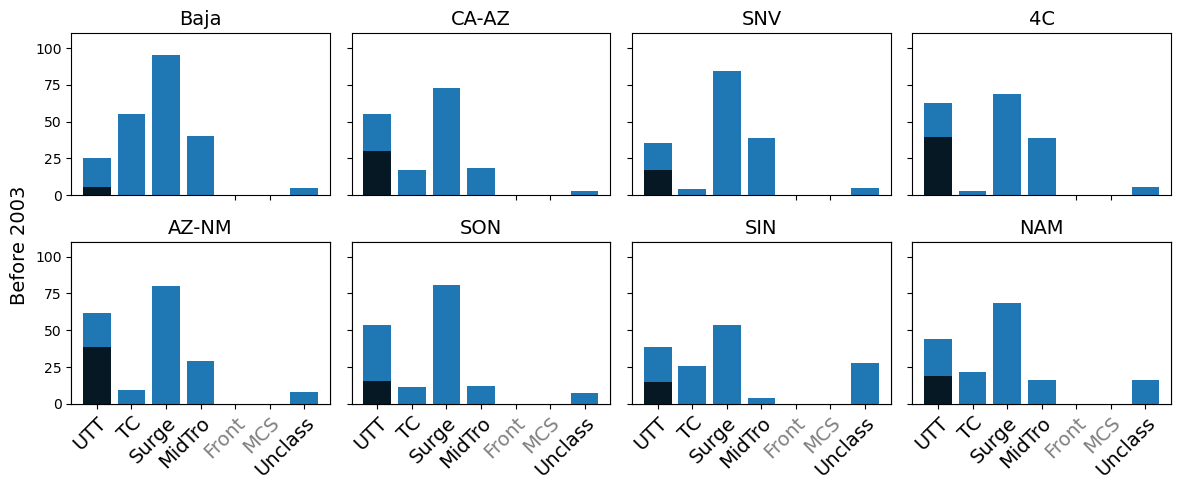

In [8]:
fig, axes = plt.subplots(figsize=(12, 5), ncols=4, nrows=2, sharey=True, sharex=True)
fontsize=14
x = np.arange(7)
xt = [0, 1, 2, 3, 6]
nam_precip = 0
nam_tutt = 0
nam_tc = 0
nam_surge = 0
nam_midtro = 0
nam_unclass = 0
nam_west_utt = 0
nam_east_utt = 0
for i in range(7):
    ind = i
    ax = axes.flatten()[i]
    if i>3:
        print(i, ind)
        ax1 = fig.add_subplot(2, 4, ind+1)
        ax1.set(yticklabels=[])  # remove the tick labels
        ax.tick_params(left=False)  # remove the ticks
        ax.set_xticks([4, 5])
        ax.set_xticklabels(["Front", "MCS"], alpha=0.5, ha="right", rotation_mode='anchor', rotation=45, fontsize=fontsize)
        ax.get_shared_x_axes().join(ax1, ax)
        ax.set_ylim([0, 110])
        sub_id = i + 1
        (total_precip, tutt_precip, tc_precip, surge_precip, midtro_precip, unclass_precip, west_utt_precip, east_utt_precip) \
        = precip_percentage_before(sub_id)
        ax1.bar(x, [tutt_precip, tc_precip, surge_precip, midtro_precip, 0, 0, unclass_precip] / total_precip * 100, color='tab:blue')
        ax1.bar(0, east_utt_precip/ total_precip * 100, color='k', alpha=0.8)
        ax1.set_xticks(xt)
        ax1.set_xticklabels(["UTT", "TC", "Surge", "MidTro", "Unclass"], rotation=45, fontsize=fontsize, 
                            # va="center", position=(0,-0.11),
                            ha="right", rotation_mode='anchor'
                          )
        ax1.set_ylim([0, 110])
    else:
        sub_id = i + 1
        (total_precip, tutt_precip, tc_precip, surge_precip, midtro_precip, unclass_precip, west_utt_precip, east_utt_precip) \
        = precip_percentage_before(sub_id)
        ax.bar(x, [tutt_precip, tc_precip, surge_precip, midtro_precip, 0, 0, unclass_precip] / total_precip * 100, color='tab:blue')
        ax.set_xticks(xt)
        ax.set_ylim([0, 110])
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([0, 25, 50, 75, 100])
    # if i>3:
        ax.set_xticklabels(["UTT", "TC", "Surge", "MidTro", "Unclass"], rotation=45, fontsize=fontsize, 
                            # va="center", position=(0,-0.11),
                            ha="right", rotation_mode='anchor'
                          )
        ax.bar(0, east_utt_precip/ total_precip * 100, color='k', alpha=0.8)
    ax.set_title(alias[sub_id], fontsize=fontsize)
    nam_precip+=total_precip
    nam_tutt+=tutt_precip
    nam_tc+=tc_precip
    nam_surge+=surge_precip
    nam_midtro+=midtro_precip
    nam_unclass+=unclass_precip
    nam_west_utt+=west_utt_precip
    nam_east_utt+=east_utt_precip
# fig.delaxes(axes[1][3])
ax = axes[1][3]
ax1 = fig.add_subplot(2, 4, 8)
ax1.set(yticklabels=[])  # remove the tick labels
ax.tick_params(left=False)  # remove the ticks
ax.set_xticks([4, 5])
ax.set_xticklabels(["Front", "MCS"], alpha=0.5, ha="right", rotation_mode='anchor', rotation=45, fontsize=fontsize)
ax.get_shared_x_axes().join(ax1, ax)
ax.set_ylim([0, 110])
ax1.bar(x, [nam_tutt, nam_tc, nam_surge, nam_midtro, 0, 0, nam_unclass] / nam_precip * 100, color='tab:blue')
ax1.bar(0, nam_east_utt/ nam_precip * 100, color='k', alpha=0.8)
ax1.set_xticks(xt)
ax1.set_xticklabels(["UTT", "TC", "Surge", "MidTro", "Unclass"], rotation=45, fontsize=fontsize, 
                    # va="center", position=(0,-0.11),
                    ha="right", rotation_mode='anchor'
                  )
ax1.set_ylim([0, 110])
ax.set_title('NAM', fontsize=fontsize)
fig.supylabel('Before 2003', fontsize=fontsize)
plt.tight_layout()
plt.savefig('PrecipBefore-NAM.png', dpi=120, bbox_inches='tight')
plt.show()

# precip after 2003

1 1
1 886.9574771032978
2 103.45645433960514
3 124.41838450425941
4 372.757277735302
5 496.217581726278
6 977.9504537707882
7 1402.6626103311203


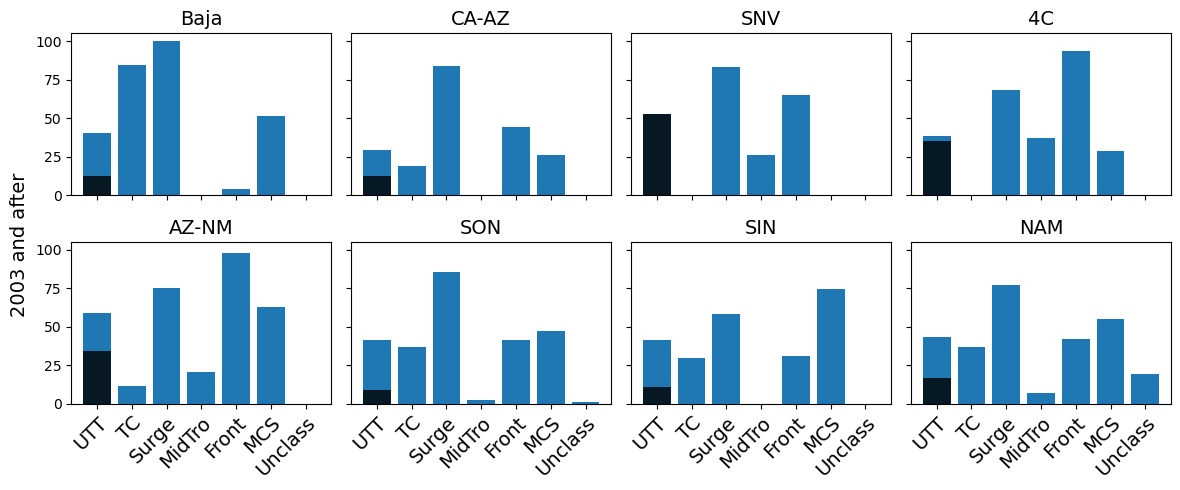

In [9]:
fig, axes = plt.subplots(figsize=(12, 5), ncols=4, nrows=2, sharex=True, sharey=True)
x = np.arange(7)
xx = np.arange(6)
fontsize = 14
nam_precip = 0
nam_tc = 0
nam_midtro = 0
nam_front = 0
nam_west_utt = 0
nam_tutt = 0
nam_surge = 0
nam_east_utt = 0
nam_mcs = 0
for i in range(7):
    ax = axes.flatten()[i]
    sub_id = i + 1
    (
        total_precip,
        tutt_precip,
        tc_precip,
        surge_precip,
        midtro_precip,
        mcs_precip,
        front_precip,
        unclass_precip, west_utt_precip, east_utt_precip, cold_precip, station_precip
    ) = precip_percentage_after(sub_id)
    ax.bar(x, [tutt_precip, tc_precip, surge_precip, midtro_precip, front_precip, mcs_precip, unclass_precip] / total_precip * 100)
    ax.set_xticks(x)
    ax.set_xticklabels(["UTT", "TC", "Surge", "MidTro", "Front", "MCS", "Unclass"], rotation=45, fontsize=fontsize, 
                        # va="center", position=(0,-0.11),
                        ha="right", rotation_mode='anchor'
                      )
    ax.set_ylim([0, 105])
    ax.set_title(alias[sub_id], fontsize=fontsize)
    ax.bar(0, east_utt_precip/total_precip*100, color='k', alpha=0.8)
    nam_precip+=total_precip
    nam_tc+=tc_precip
    nam_midtro+=midtro_precip
    nam_front+=front_precip
    nam_tutt+=tutt_precip
    nam_mcs+=mcs_precip
    nam_east_utt+=east_utt_precip
    nam_surge+=surge_precip
    print(sub_id, total_precip)
plt.tight_layout()
ax = axes[1][3]
ax.set_ylim([0, 105])
ax.bar(x, [nam_tutt, nam_tc, nam_surge, nam_midtro, nam_front, nam_mcs, nam_unclass] / nam_precip * 100, color='tab:blue')
ax.bar(0, nam_east_utt/ nam_precip * 100, color='k', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(["UTT", "TC", "Surge", "MidTro", "Front", "MCS", "Unclass"], rotation=45, fontsize=fontsize, 
                        # va="center", position=(0,-0.11),
                        ha="right", rotation_mode='anchor'
                      )
ax.set_title('NAM', fontsize=fontsize)
fig.supylabel('2003 and after', fontsize=fontsize)
plt.tight_layout()
plt.savefig('PrecipAfter-NAM.png', dpi=120, bbox_inches='tight')
plt.show()

In [10]:
nam_east_utt

737.68929636073

In [11]:
nam_tutt

1880.078963487586

# Number of Events functions

## before 2003

In [12]:
def events_percentage_before(sub_id):
    # surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surge_induced_flag.npy")
    surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
    # tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
    tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
    tutt_direction = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_direction-10degree.npy")
    # tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
    tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_corrected_flag.npy")
    MCS_induced_flag = np.load("../ERA5/PAU/MCS_" + str(sub_id) + ".npy")
    MCS_induced_flag[MCS_induced_flag < 0] = 0
    midtro_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
    front_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_front.npy")
    start, end = start_end_time(sub_id)
    end_0 = [time - np.timedelta64(12, "h") for time in end]
    start_0 = [time - np.timedelta64(12, "h") for time in start]
    years = np.array(list(pd.to_datetime(end_0).year))
    diff = years - 2003
    ind = np.where(diff >= 0)[0][0]
    # print(years, " ", len(end_0), " ", len(midtro_flag), ind, " ", years[ind])
    midtro_time = 0
    tutt_time = 0
    west_utt_time = 0
    east_utt_time = 0
    surge_time = 0
    tc_time = 0
    unclass_time = 0
    total_events = 0
    for i in range(ind):
        if tutt_induced_flag[i] > 0:
            tutt_time += 1
            if tutt_direction[i]>0:
                west_utt_time+=1
            else:
                east_utt_time+=1
        if tc_induced_flag[i] > 0:
            tc_time += 1
        if surge_induced_flag[i] > 0:
            surge_time += 1
        if midtro_flag[i] > 0:
            midtro_time += 1
        if tutt_induced_flag[i] <= 0 and surge_induced_flag[i] <= 0 and tc_induced_flag[i] <= 0 and midtro_flag[i] <= 0:
            unclass_time += 1
        total_events += 1
    return total_events, tutt_time, tc_time, surge_time, midtro_time, unclass_time, west_utt_time, east_utt_time


## after 2003

In [13]:
def events_percentage_after(sub_id):
    # surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surge_induced_flag.npy")
    surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
    # tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
    tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
    tutt_direction = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_direction-10degree.npy")
    # tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
    tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_corrected_flag.npy")
    MCS_induced_flag = np.load("../ERA5/PAU/MCS_" + str(sub_id) + ".npy")
    MCS_induced_flag[MCS_induced_flag < 0] = 0
    midtro_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
    front_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_front.npy")
    with open("../ERA5/PAU/front_type_" + str(sub_id) + ".pickle", 'rb') as f:
        front_type = pickle.load(f)
    start, end = start_end_time(sub_id)
    end_0 = [time - np.timedelta64(12, "h") for time in end]
    start_0 = [time - np.timedelta64(12, "h") for time in start]
    years = np.array(list(pd.to_datetime(end_0).year))
    diff = years - 2003
    ind = np.where(diff >= 0)[0][0]
    # print(years, " ", len(end_0), " ", len(midtro_flag), ind, " ", years[ind])
    MCS_time = 0
    tutt_time = 0
    west_utt_time = 0
    east_utt_time = 0
    surge_time = 0
    tc_time = 0
    midtro_time = 0
    front_time = 0
    unclass_time = 0
    total_events = 0
    cold_time = 0
    station_time = 0
    for i in range(ind, len(end_0)):
        if tutt_induced_flag[i] > 0:
            tutt_time += 1
            if tutt_direction[i]>0:
                west_utt_time+=1
            else:
                east_utt_time+=1
        if tc_induced_flag[i] > 0:
            tc_time += 1
        if surge_induced_flag[i] > 0:
            surge_time += 1
        if midtro_flag[i] > 0:
            midtro_time += 1
        if front_flag[i] > 0:
            front_time += 1
            types = front_type[i]
            m = scipy.stats.mode(types)
            if m[0][0]==0:
                cold_time+=1
            elif m[0][0]==2:
                station_time+=1
            else:
                print(sub_id, m[0][0])
            
        if MCS_induced_flag[i] > 0:
            MCS_time += 1
        if (
            tutt_induced_flag[i] <= 0
            and surge_induced_flag[i] <= 0
            and tc_induced_flag[i] <= 0
            and MCS_induced_flag[i] <= 0
            and front_flag[i] <= 0
            and midtro_flag[i] <= 0
        ):
            unclass_time += 1
        total_events += 1
    return total_events, tutt_time, tc_time, surge_time, midtro_time, MCS_time, front_time, unclass_time, west_utt_time, east_utt_time, cold_time, station_time

# Events before 2003

4 4
5 5
6 6


/tmp/ipykernel_16469/3048036835.py:23: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax1, ax)
/tmp/ipykernel_16469/3048036835.py:23: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax1, ax)
/tmp/ipykernel_16469/3048036835.py:23: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax1, ax)
/tmp/ipykernel_16469/3048036835.py:64: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax1, ax)


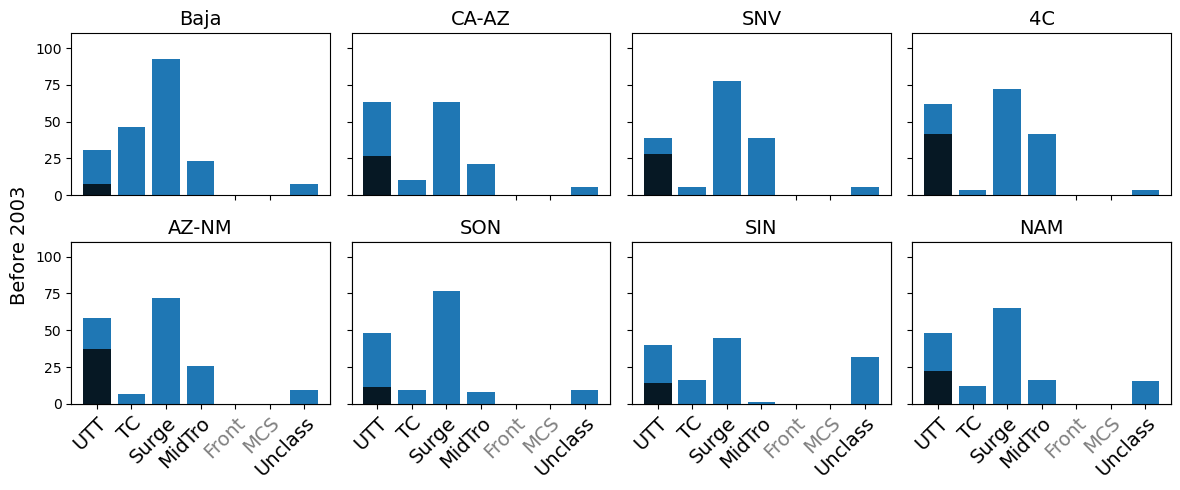

In [14]:
fig, axes = plt.subplots(figsize=(12, 5), ncols=4, nrows=2, sharey=True, sharex=True)
fontsize=14
x = np.arange(7)
xt = [0, 1, 2, 3, 6]
nam_precip = 0
nam_tutt = 0
nam_tc = 0
nam_surge = 0
nam_midtro = 0
nam_unclass = 0
nam_west_utt = 0
nam_east_utt = 0
for i in range(7):
    ind = i
    ax = axes.flatten()[i]
    if i>3:
        print(i, ind)
        ax1 = fig.add_subplot(2, 4, ind+1)
        ax1.set(yticklabels=[])  # remove the tick labels
        ax.tick_params(left=False)  # remove the ticks
        ax.set_xticks([4, 5])
        ax.set_xticklabels(["Front", "MCS"], alpha=0.5, ha="right", rotation_mode='anchor', rotation=45, fontsize=fontsize)
        ax.get_shared_x_axes().join(ax1, ax)
        ax.set_ylim([0, 110])
        sub_id = i + 1
        total_events, tutt_time, tc_time, surge_time, midtro_time, unclass_time, west_utt_time, east_utt_time = events_percentage_before(sub_id)
        ax1.bar(x, [tutt_time, tc_time, surge_time, midtro_time, 0, 0, unclass_time] / np.array(total_events) * 100)
        ax1.bar(0, east_utt_time/ np.array(total_events) * 100, color='k', alpha=.8)
        ax1.set_xticks(xt)
        ax1.set_xticklabels(["UTT", "TC", "Surge", "MidTro", "Unclass"], rotation=45, fontsize=fontsize, 
                            # va="center", position=(0,-0.11),
                            ha="right", rotation_mode='anchor'
                          )
        ax1.set_ylim([0, 110])
    else:
        sub_id = i + 1
        total_events, tutt_time, tc_time, surge_time, midtro_time, unclass_time, west_utt_time, east_utt_time = events_percentage_before(sub_id)
        ax.bar(x, [tutt_time, tc_time, surge_time, midtro_time, 0, 0, unclass_time] / np.array(total_events) * 100)
        ax.bar(0, east_utt_time/ np.array(total_events) * 100, color='k', alpha=.8)
        ax.set_xticks(xt)
        ax.set_ylim([0, 110])
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([0, 25, 50, 75, 100])
    # if i>3:
        ax.set_xticklabels(["UTT", "TC", "Surge", "MidTro", "Unclass"], rotation=45, fontsize=fontsize, 
                            # va="center", position=(0,-0.11),
                            ha="right", rotation_mode='anchor'
                          )
    ax.set_title(alias[sub_id], fontsize=fontsize)
    nam_precip+=total_events
    nam_tutt+=tutt_time
    nam_tc+=tc_time
    nam_surge+=surge_time
    nam_midtro+=midtro_time
    nam_unclass+=unclass_time
    nam_west_utt+=west_utt_time
    nam_east_utt+=east_utt_time
ax = axes[1][3]
ax1 = fig.add_subplot(2, 4, 8)
ax1.set(yticklabels=[])  # remove the tick labels
ax.tick_params(left=False)  # remove the ticks
ax.set_xticks([4, 5])
ax.set_xticklabels(["Front", "MCS"], alpha=0.5, ha="right", rotation_mode='anchor', rotation=45, fontsize=fontsize)
ax.get_shared_x_axes().join(ax1, ax)
ax.set_ylim([0, 110])
ax1.bar(x, [nam_tutt, nam_tc, nam_surge, nam_midtro, 0, 0, nam_unclass] / np.array(nam_precip) * 100)
ax1.bar(0, nam_east_utt/ np.array(nam_precip) * 100, color='k', alpha=.8)
ax1.set_xticks(xt)
ax1.set_xticklabels(["UTT", "TC", "Surge", "MidTro", "Unclass"], rotation=45, fontsize=fontsize, 
                    # va="center", position=(0,-0.11),
                    ha="right", rotation_mode='anchor'
                  )
ax1.set_ylim([0, 110])
ax.set_title('NAM', fontsize=fontsize)
fig.supylabel('Before 2003', fontsize=fontsize)
plt.tight_layout()
plt.savefig('EventsBefore-NAM.png', dpi=120, bbox_inches='tight')
plt.show()

In [15]:
print(tutt_time-west_utt_time-east_utt_time)

0


# Events after 2003

1 1


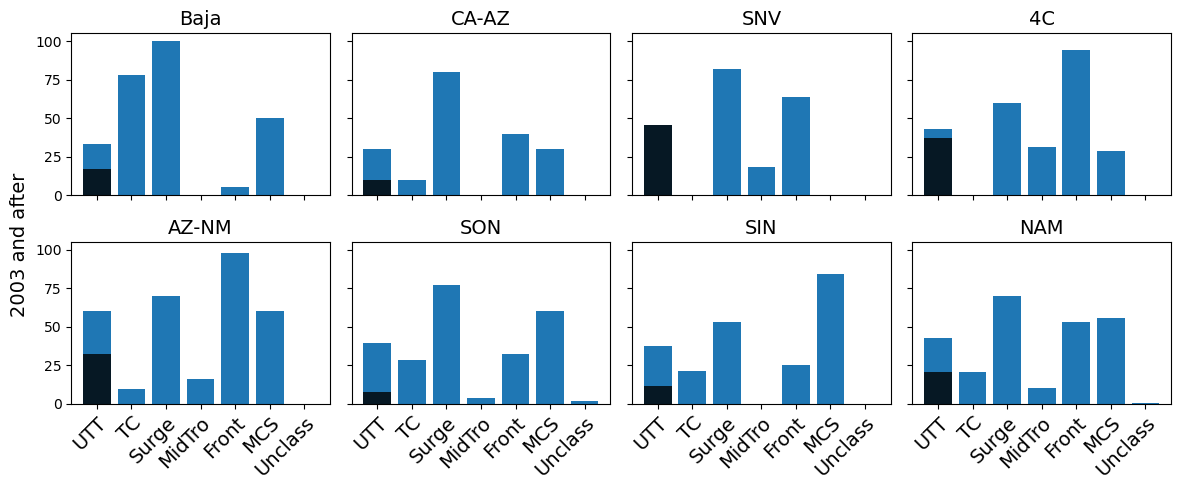

In [16]:
fig, axes = plt.subplots(figsize=(12, 5), ncols=4, nrows=2, sharex='col', sharey=True)
x = np.arange(7)
nam_precip = 0
nam_tutt = 0
nam_tc = 0
nam_surge = 0
nam_midtro = 0
nam_mcs = 0
nam_front = 0
nam_unclass = 0
nam_east_utt = 0
for i in range(7):
    ax = axes.flatten()[i]
    sub_id = i + 1
    total_events, tutt_time, tc_time, surge_time, midtro_time, MCS_time, front_time, unclass_time, west_utt_time, east_utt_time, cold_time, station_time = events_percentage_after(sub_id)
    ax.bar(x, [tutt_time, tc_time, surge_time, midtro_time, front_time, MCS_time, unclass_time] / np.array(total_events) * 100)
    ax.set_xticks(x)
    ax.set_xticklabels(["UTT", "TC", "Surge", "MidTro", "Front", "MCS", "Unclass"], rotation=45, fontsize=fontsize, 
                        # va="center", position=(0,-0.11),
                        ha="right", rotation_mode='anchor'
                      )
    ax.set_title(alias[sub_id], fontsize=fontsize)
    ax.bar(0, east_utt_time/total_events*100, color='k', alpha=0.8)
    nam_precip+=total_events
    nam_tutt+=tutt_time
    nam_tc+=tc_time
    nam_surge+=surge_time
    nam_midtro+=midtro_time
    nam_mcs+=MCS_time
    nam_front+=front_time
    nam_unclass+=unclass_time
    nam_east_utt+=east_utt_time
ax = axes[1][3]
ax.bar(x, [nam_tutt, nam_tc, nam_surge, nam_midtro, nam_front, nam_mcs, nam_unclass] / np.array(nam_precip) * 100)
ax.set_xticks(x)
ax.set_xticklabels(["UTT", "TC", "Surge", "MidTro", "Front", "MCS", "Unclass"], rotation=45, fontsize=fontsize, 
                    # va="center", position=(0,-0.11),
                    ha="right", rotation_mode='anchor'
                  )
ax.set_title("NAM", fontsize=fontsize)
ax.bar(0, nam_east_utt/nam_precip*100, color='k', alpha=0.8)
fig.supylabel('2003 and after', fontsize=fontsize)
plt.tight_layout()

plt.savefig('EventsAfter-NAM.png', dpi=120, bbox_inches='tight')
plt.show()

# Single

In [17]:
def timerange(start, end):
    times = []
    days = int((end - start) / np.timedelta64(1, "D"))
    for i in range(days):
        times.append(end - np.timedelta64(i, "D"))
    return times
def get_precip(times, sub_id):
    # print(sub_id, ' SUB_ID')
    flat_times = [item for sublist in times for item in sublist]
    precip = monsoon_precip.sel(time=flat_times, sub_id=sub_id).sum().data if len(flat_times) > 0 else 0
    return precip

In [18]:
def get_bool_complex(tc_induced_flag, surge_induced_flag, tutt_induced_flag, midtro_flag, front_flag, MCS_induced_flag):
    tc = tc_induced_flag.astype(bool)
    surge = surge_induced_flag.astype(bool)
    tutt = tutt_induced_flag.astype(bool)
    midtro = midtro_flag.astype(bool)
    front = front_flag.astype(bool)
    mcs = MCS_induced_flag.astype(bool)
    # All
    all_flag = (tc) & (surge) & (tutt) & (midtro) & (front) & (mcs)
    # 1-way
    tc_sole = (tc) & (~surge) & (~tutt) & (~midtro) & (~front) & (~mcs)
    surge_sole = (~tc) & (surge) & (~tutt) & (~midtro) & (~front) & (~mcs)
    tutt_sole = (~tc) & (~surge) & (tutt) & (~midtro) & (~front) & (~mcs)
    midtro_sole = (~tc) & (~surge) & (~tutt) & (midtro) & (~front) & (~mcs)
    front_sole = (~tc) & (~surge) & (~tutt) & (~midtro) & (front) & (~mcs)
    mcs_sole = (~tc) & (~surge) & (~tutt) & (~midtro) & (~front) & (mcs)
    one_way = [tc_sole, surge_sole, tutt_sole, midtro_sole, front_sole, mcs_sole]
    

    return (all_flag, one_way)

In [19]:
def get_precip_complex(way_list, ind, start_0, end_0, sub_id):
    l = len(way_list)
    results = [[] for i in range(l)]
    for j, bool_way in enumerate(way_list):
        for i in range(ind, len(end_0)):
            if bool_way[i]:
                times = timerange(start_0[i], end_0[i])
                results[j].append(times)
    precip_results = []
    # print(results)
    for j, bool_time in enumerate(results):
        if len(bool_time) > 0:
            precip_results.append(get_precip(bool_time, sub_id=sub_id))
        else:
            precip_results.append(0)
    return results, precip_results


def precip_percentage_after_complex(sub_id):
    surge_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
    # tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
    tutt_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
    tc_induced_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
    MCS_induced_flag = np.load("../ERA5/PAU/MCS_" + str(sub_id) + ".npy")
    MCS_induced_flag[MCS_induced_flag < 0] = 0
    midtro_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
    front_flag = np.load("../ERA5/PAU/" + str(sub_id) + "_front.npy")

    (all_flag, one_way) = get_bool_complex(
        tc_induced_flag, surge_induced_flag, tutt_induced_flag, midtro_flag, front_flag, MCS_induced_flag
    )

    start, end = start_end_time(sub_id)
    end_0 = [time - np.timedelta64(12, "h") for time in end]
    start_0 = [time - np.timedelta64(12, "h") for time in start]
    years = np.array(list(pd.to_datetime(end_0).year))
    diff = years - 2003
    ind = np.where(diff >= 0)[0][0]
    print(sub_id, ' SUB_ID: ', ind, ' ', len(end_0))
    results_1, precip_results_1 = get_precip_complex(one_way, ind, start_0, end_0, sub_id=sub_id)    

    total_time = []
    for i in range(ind, len(end_0)):
        times = timerange(start_0[i], end_0[i])
        total_time.append(times)
    total_precip = get_precip(total_time, sub_id=sub_id)

    return (
        total_precip,
        precip_results_1,
    )

/tmp/ipykernel_16469/1439239342.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('copper')


2  SUB_ID:  19   29
[0, array(27.36555702), array(8.20765721), 0, array(8.43877623), 0]
3  SUB_ID:  18   29
[0, array(23.89034313), array(10.59260964), 0, array(10.11205031), 0]
4  SUB_ID:  29   64
[0, array(16.54474082), 0, 0, array(27.96341511), 0]
5  SUB_ID:  43   86
[0, 0, 0, 0, array(23.1531576), array(11.39847619)]
6  SUB_ID:  52   105
[0, array(72.77703212), 0, 0, 0, array(36.40621495)]
7  SUB_ID:  85   136
[0, array(25.14878956), 0, 0, 0, array(160.39294299)]


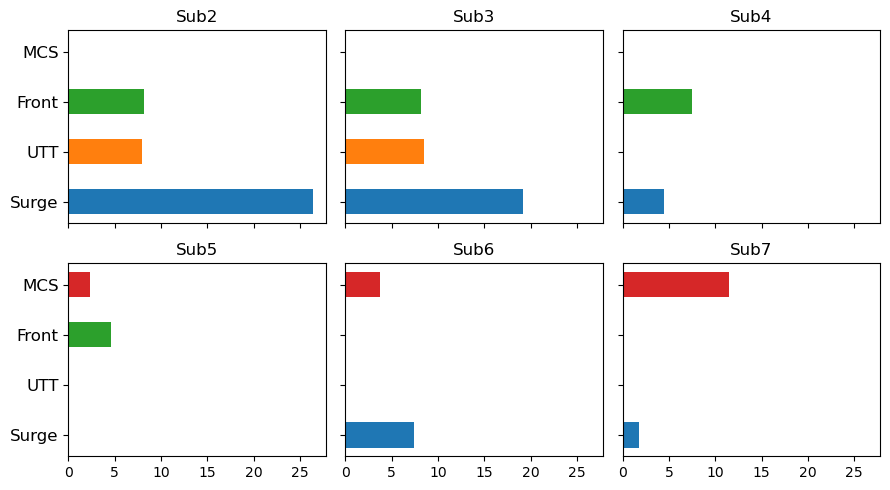

In [20]:
import matplotlib
from matplotlib import cm
cmap = cm.get_cmap('copper')
one_names = ['TC', 'Surge', 'UTT', 'Midtro', 'Front', 'MCS']
keep_names = ['Surge', 'UTT', 'Front', 'MCS']
fig, axes = plt.subplots(figsize=(9, 5), ncols=3, nrows=2, sharey=True, sharex=True)
x = np.arange(7)
xx = np.arange(6)
for i in range(1, 7):
    ax = axes.flatten()[i-1]
    sub_id = i + 1
    (
    total_precip,
    precip_results_1,
    ) = precip_percentage_after_complex(sub_id)
    precip_all = [precip_results_1]
    print(precip_results_1)
    x = 0
    bar_names = []
    for i, p in enumerate(precip_all):
        p_sub = [p[1], p[2], p[4], p[5]]
        for j, ind_p in enumerate(p_sub):
            # if ind_p>0:
            #     rgba = cmap(x/14)
            ax.barh(j, ind_p/total_precip*100, height=0.5)
                # print(i, j, names[i][j], ind_p)
                # bar_names.append(abbs[i][j])
                # x+=1
    ax.set_yticks(np.arange(4))
    ax.set_yticklabels(keep_names, rotation=0, fontsize=12)
    ax.set_title('Sub'+str(sub_id), fontsize=12)
plt.tight_layout()
# fig.delaxes(axes[2][1])
# fig.delaxes(axes[2][2])
# plt.savefig('ComplexInteract.png', dpi=120, bbox_inches='tight')
plt.show() 

/tmp/ipykernel_16469/596533306.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('copper')


2  SUB_ID:  19   29
[0, array(27.36555702), array(8.20765721), 0, array(8.43877623), 0]
3  SUB_ID:  18   29
[0, array(23.89034313), array(10.59260964), 0, array(10.11205031), 0]
4  SUB_ID:  29   64
[0, array(16.54474082), 0, 0, array(27.96341511), 0]
5  SUB_ID:  43   86
[0, 0, 0, 0, array(23.1531576), array(11.39847619)]
6  SUB_ID:  52   105
[0, array(72.77703212), 0, 0, 0, array(36.40621495)]
7  SUB_ID:  85   136
[0, array(25.14878956), 0, 0, 0, array(160.39294299)]


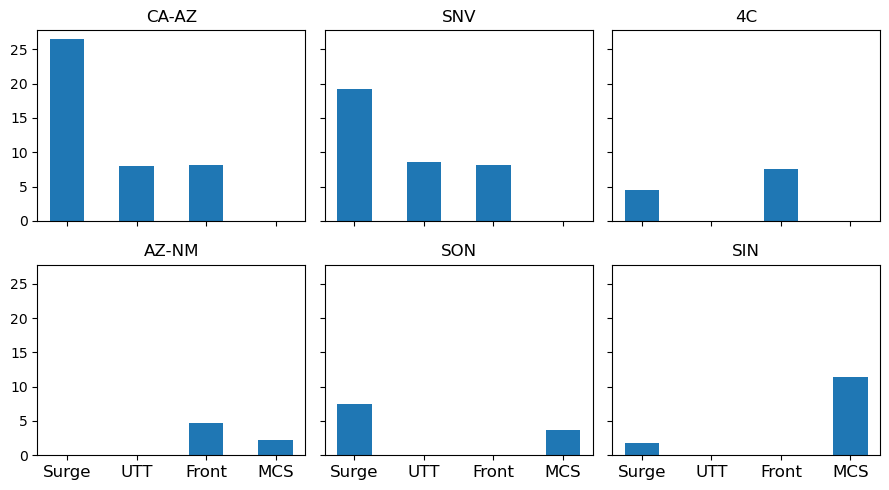

In [21]:
import matplotlib
from matplotlib import cm
cmap = cm.get_cmap('copper')
one_names = ['TC', 'Surge', 'UTT', 'Midtro', 'Front', 'MCS']
keep_names = ['Surge', 'UTT', 'Front', 'MCS']
fig, axes = plt.subplots(figsize=(9, 5), ncols=3, nrows=2, sharey=True, sharex=True)
x = np.arange(7)
xx = np.arange(6)
for i in range(1, 7):
    ax = axes.flatten()[i-1]
    sub_id = i + 1
    (
    total_precip,
    precip_results_1,
    ) = precip_percentage_after_complex(sub_id)
    precip_all = [precip_results_1]
    print(precip_results_1)
    x = 0
    bar_names = []
    for i, p in enumerate(precip_all):
        p_sub = [p[1], p[2], p[4], p[5]]
        for j, ind_p in enumerate(p_sub):
            # if ind_p>0:
            #     rgba = cmap(x/14)
            ax.bar(j, ind_p/total_precip*100, width=0.5, color='tab:blue')
                # print(i, j, names[i][j], ind_p)
                # bar_names.append(abbs[i][j])
                # x+=1
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(keep_names, rotation=0, fontsize=12)
    ax.set_title(alias[sub_id], fontsize=12)
plt.tight_layout()
plt.savefig('UniqueDriver.png', dpi=120, bbox_inches='tight')
plt.show() 